In [14]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Definir el directorio donde se extraen los archivos y las rutas para los conjuntos de datos



In [15]:
dataset_dir = r'C:\Users\dcouto\Desktop\Nueva carpeta\archive\real_vs_fake\real-vs-fake'

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')


Definir las transformaciones usando ImageDataGenerator


In [16]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

- **`rescale=1.0/255`**: Normaliza los valores de los píxeles de las imágenes a un rango entre 0 y 1. Esto es útil ya que los valores de los píxeles suelen estar entre 0 y 255, y al dividirlos por 255 obtenemos valores que ayudan a estabilizar y mejorar el rendimiento del modelo.

- **`rotation_range=40`**: Rota aleatoriamente las imágenes hasta un máximo de 40 grados. Esto permite que el modelo sea robusto ante variaciones de rotación en los datos de entrada.

- **`width_shift_range=0.2`**: Desplaza las imágenes horizontalmente hasta un 20% del ancho de la imagen. Esto ayuda a que el modelo se adapte a desplazamientos laterales en los datos.

- **`height_shift_range=0.2`**: Desplaza las imágenes verticalmente hasta un 20% de la altura de la imagen. Esto permite que el modelo tolere variaciones en la posición vertical de los objetos.

- **`shear_range=0.2`**: Aplica una transformación de **cizalladura (shear)** con un ángulo de 20%. Esto distorsiona la imagen en el eje horizontal o vertical, proporcionando variabilidad en la geometría de los objetos, lo que ayuda al modelo a aprender características de forma más general.

- **`zoom_range=0.2`**: Hace un **zoom aleatorio** en la imagen, ampliándola o reduciéndola hasta un 20%. Esto permite al modelo adaptarse a diferentes escalas de objetos en las imágenes.

- **`horizontal_flip=True`**: Invierte las imágenes horizontalmente. Esta transformación es especialmente útil en conjuntos de datos donde la orientación izquierda/derecha del objeto no es relevante y permite generar más variedad en las imágenes.

- **`fill_mode='nearest'`**: Especifica cómo rellenar los píxeles que quedan vacíos después de las transformaciones. Con `fill_mode='nearest'`, los píxeles vacíos se llenan con el valor del píxel más cercano, evitando bordes o espacios vacíos en las imágenes transformadas.


Cargar datasets


In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


Cargar y compilar el modelo 

In [8]:

# Cargar el modelo preentrenado VGG16
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base del modelo
base_model.trainable = False

# Crear el modelo completo
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria (real o fake)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Carga el modelo preentrenado VGG16 y congela sus capas para que no se actualicen durante el entrenamiento. Esto permite aprovechar las características aprendidas previamente y evitar el sobreajuste. Se añade una capa de aplanado para convertir la salida multidimensional en un vector unidimensional, seguida de una capa densa con 512 neuronas y activación ReLU para extraer características complejas y otra capa densa para clasificar imágenes como "reales" o "falsas". Se compila el modelo utilizando el optimizador Adam y la pérdida de entropía cruzada binaria.








Entrenamiento

In [18]:
# Entrenamiento del modelo
num_epochs = 5  # Ajusta el número de épocas según sea necesario
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=num_epochs
)


Epoch 1/5
625/625 [==============================] - 2336s 4s/step - loss: 0.5724 - accuracy: 0.6980 - val_loss: 0.5074 - val_accuracy: 0.7550
Epoch 2/5
625/625 [==============================] - 2382s 4s/step - loss: 0.5481 - accuracy: 0.7219 - val_loss: 0.4982 - val_accuracy: 0.7591
Epoch 3/5
625/625 [==============================] - 2379s 4s/step - loss: 0.5466 - accuracy: 0.7196 - val_loss: 0.4938 - val_accuracy: 0.7560
Epoch 4/5
625/625 [==============================] - 2358s 4s/step - loss: 0.5494 - accuracy: 0.7207 - val_loss: 0.4870 - val_accuracy: 0.7656
Epoch 5/5
625/625 [==============================] - 2357s 4s/step - loss: 0.5401 - accuracy: 0.7236 - val_loss: 0.5082 - val_accuracy: 0.7455


Evaluación

In [19]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Accuracy en el conjunto de prueba: {test_accuracy * 100:.2f}%')

625/625 [==============================] - 2075s 3s/step - loss: 0.5057 - accuracy: 0.7509
Accuracy en el conjunto de prueba: 75.09%


Pintar historia de entrenamiento

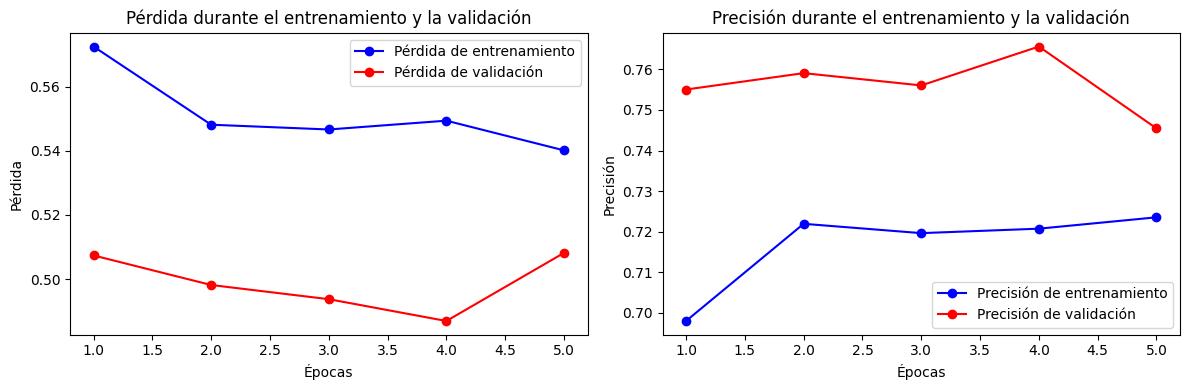

In [20]:
import matplotlib.pyplot as plt

# Asume que 'history' es el resultado de model.fit()
history_dict = history.history

# Obtener los datos de pérdida y precisión
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Crear el rango de épocas
epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'ro-', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


Guardare modelo


In [21]:
model.save("VGGNet_Keras2.h5")

c:\Users\dcouto\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Enlace modelo entrenado con 10 epoch con un resultado de 0,75 de accuracy: https://drive.google.com/file/d/1mCluk4oAkDK4X1y1O-VXYbbrnyLXovg4/view?usp=drive_link

# Investigación sobre VGGNet


La empresa Visual Geometry Group creó VGGNet (de la Universidad de Oxford). Es un diseño típico de Red Neuronal Convolucional (CNN) profunda con numerosas capas, y la abreviatura VGG significa Visual Geometry Group. El término "profunda" describe el número de capas, siendo VGG-16 o VGG-19 las versiones con 16 o 19 capas de convolución, respectivamente (la usada arriba tiene 16).

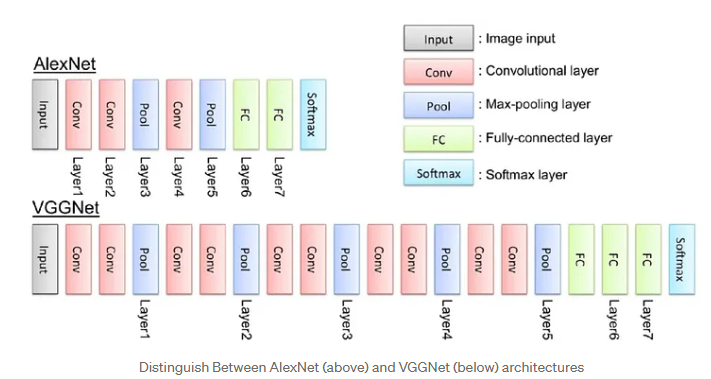

- **Input**: Entrada de imagen.
- **Conv** (rojo): Capa convolucional, extrae características o patrones específicos de una imagen.
- **Pool** (azul): Capa de max-pooling, que reduce la dimensión de la imagen para mantener las características importantes mientras reduce la carga computacional.
- **FC** (verde): Capa totalmente conectada (Fully-connected), donde cada neurona se conecta a todas las neuronas de la capa anterior.
- **Softmax** (azul claro): Capa de Softmax, que convierte las salidas en probabilidades para la clasificación final.


ImageNet es un conjunto de datos que contiene más de 14 millones de imágenes divididas en casi 1000 categorías. VGG16 fue uno de los modelos más populares presentados en el ILSVRC-2014 (ImageNet Large Scale Visual Recognition Challenge).Supera significativamente a AlexNet al utilizar múltiples filtros de tamaño de núcleo 3x3 en lugar de filtros de gran tamaño.

La red VGG se construye utilizando filtros de convolución muy pequeños. VGG-16 consta de trece capas de convolución y tres capas completamente conectadas.

## Arquitectura de VGG-Net

- **Entradas**: VGGNet acepta imágenes de **224 x 224 píxeles** como entrada. Para mantener un tamaño de entrada consistente en la competencia ImageNet.

- **Capas Convolucionales**: Las capas de convolución de VGG utilizan el **campo receptivo más pequeño posible**, de tamaño \(3 \times 3\), para capturar movimientos de izquierda a derecha y de arriba a abajo. Además, se emplean filtros de \(1 \times 1\) para transformar la entrada linealmente. Después de cada capa convolucional, se utiliza una unidad **ReLU** (Rectified Linear Unit), que fue un avance importante en comparación con AlexNet, ya que reduce el tiempo de entrenamiento. La función de activación ReLU es una función lineal a tramos: si la entrada es positiva, produce la misma entrada; de lo contrario, la salida es cero. El **stride** en la convolución está fijado en **1 píxel**, para mantener la resolución espacial después de la convolución.

- **Capas Ocultas**: Todas las capas ocultas de VGG utilizan **ReLU** como función de activación. La **Normalización de Respuesta Local** (LRN) no se usa típicamente en VGG, ya que incrementa el uso de memoria y el tiempo de entrenamiento, sin mejorar la precisión general.

- **Capas Completamente Conectadas**: VGGNet contiene **tres capas completamente conectadas**. Las primeras dos capas tienen **4096 canales** cada una, mientras que la tercera capa tiene **1000 canales**, con un canal para cada clase.


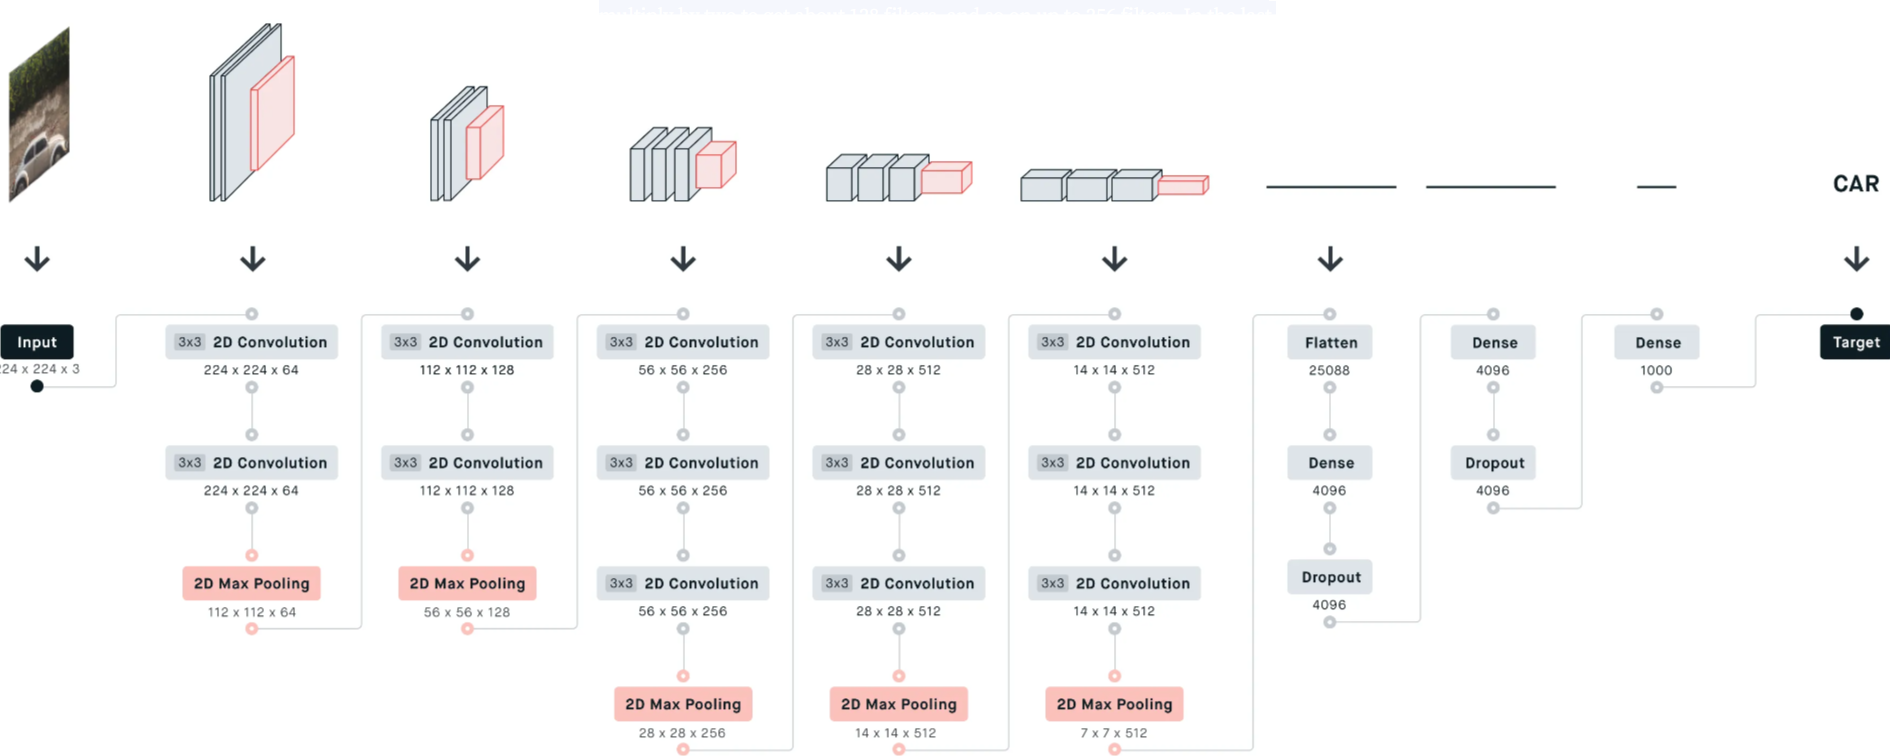

## Limitaciones de VGG-16

- **Entrenamiento muy lento**: El modelo VGG original fue entrenado en una GPU Nvidia Titan durante **2–3 semanas**, lo que hace que su entrenamiento sea considerablemente lento.
- **Gran tamaño de los pesos entrenados**: Los pesos entrenados de VGG-16 en ImageNet ocupan **528 MB**. Esto consume una gran cantidad de espacio en disco y ancho de banda, lo cual lo vuelve ineficiente.
- **Cantidad de parámetros**: Con **138 millones de parámetros**, VGG-16 es propenso al problema de **gradientes explosivos**.
